In [1]:
import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import scvi
import torch

import pandas as pd
from gprofiler import GProfiler

import seaborn as sb
from matplotlib import colors
from matplotlib import rcParams


torch.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

scvi.settings.seed = 0
print(scvi.__version__)

/home/hbolouri/mambaforge/envs/ldVAE_env/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/hbolouri/mambaforge/envs/ldVAE_env/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
Global seed set to 0


1.0.4


In [2]:
adata = scvi.data.read_h5ad("/mnt/d/scGPT/ldVAE/selPerez.h5ad")

In [3]:
adata # subset ==  Perez et al PBMCs from healthy donors & SLE Flare cases

AnnData object with n_obs × n_vars = 541538 × 1999
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids'
    uns: '_scvi_manager_uuid', '_scvi_uuid'
    layers: 'counts'

In [2]:
# Load trained models

# 1) Z14 in all pops. ***
# Default paras except n_latent = 15 --> 1L.128.H.15L,250E
model_1L128H14 = scvi.model.LinearSCVI.load(
    "/mnt/d/scGPT/ldVAE/ldVAE_Perez_model22Jan2024")

# 2) Z2 in all pops   ***
model_1L128H8L250E = scvi.model.LinearSCVI.load(
    "/mnt/d/scGPT/ldVAE/ldVAE_Perez_1L.128H.8L.250E", adata = adata)

# 3) Z5 in all pops   ***
model_2L64H8L250E = scvi.model.LinearSCVI.load(
    "/mnt/d/scGPT/ldVAE/ldVAE_Perez_2L.64H.8L.250E", adata = adata)

# 4) Z1 (monos, cDC) & Z6 (all n/a B)
model_1L64H8L250E = scvi.model.LinearSCVI.load(
    "/mnt/d/scGPT/ldVAE/ldVAE_Perez_1L.64H.8L.250E", adata = adata)

# 5) Z4 (all monos), Z3 (weak), Z2 (aB)
model_2L32H8L250E = scvi.model.LinearSCVI.load(
    "/mnt/d/scGPT/ldVAE/ldVAE_Perez_2L.32H.8L.250E", adata = adata)

INFO     File /mnt/d/scGPT/ldVAE/ldVAE_Perez_model22Jan2024/model.pt already downloaded                            


/home/hbolouri/mambaforge/envs/ldVAE_env/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



In [3]:
# Get top 25 genes per loading for each model of interest:

loadings1 = model_1L128H14.get_loadings()
sel1 = loadings1["Z_14"].sort_values().head(25)
genes1 = sel1.index.values

loadings2 = model_1L128H8L250E.get_loadings()
sel2 = loadings2["Z_2"].sort_values().tail(25)
genes2 = sel2.index.values

loadings3 = model_2L64H8L250E.get_loadings()
sel3 = loadings3["Z_5"].sort_values().tail(25)
genes3 = sel3.index.values

loadings4 = model_1L64H8L250E.get_loadings()
sel4_1 = loadings4["Z_1"].sort_values().tail(25)
sel4_2 = loadings4["Z_6"].sort_values().tail(25)
genes4_Z1 = sel4_1.index.values
genes4_Z6 = sel4_2.index.values
genes4_all = np.concatenate((sel4_1.index.values, 
                             sel4_2.index.values)) # 50

loadings5 = model_2L32H8L250E.get_loadings()
sel5_1 = loadings5["Z_4"].sort_values().tail(25)
sel5_2 = loadings5["Z_3"].sort_values().tail(25)
sel5_3 = loadings5["Z_2"].sort_values().head(25)
genes5_Z4 = sel5_1.index.values
genes5_Z3 = sel5_2.index.values
genes5_Z2 = sel5_3.index.values
genes5_all = np.concatenate((sel5_1.index.values, 
                             sel5_2.index.values,
                             sel5_3.index.values)) # 75

In [7]:
gp = GProfiler(return_dataframe=True)

tbl1 = gp.profile(organism='hsapiens', query=list(genes1))
tbl2 = gp.profile(organism='hsapiens', query=list(genes2))
tbl3 = gp.profile(organism='hsapiens', query=list(genes3))

tbl4_Z1 = gp.profile(organism='hsapiens', query=list(genes4_Z1))
tbl4_Z6 = gp.profile(organism='hsapiens', query=list(genes4_Z6))
tbl4_all = gp.profile(organism='hsapiens', query=list(genes4_all))

tbl5_Z4 = gp.profile(organism='hsapiens', query=list(genes5_Z4))
tbl5_Z3 = gp.profile(organism='hsapiens', query=list(genes5_Z3))
tbl5_Z2 = gp.profile(organism='hsapiens', query=list(genes5_Z2))
tbl5_all = gp.profile(organism='hsapiens', query=list(genes5_all))

In [8]:
# GProfiler plot functions below are slightly modified versions of:
# https://github.com/theislab/single-cell-tutorial/blob/master/latest_notebook/gprofiler_plotting.py

# Plotting functions for 'GProfiler-official version'
# import seaborn as sb
# from matplotlib import colors
# from matplotlib import rcParams


def scale_data_5_75(data):
    mind = np.min(data)
    maxd = np.max(data)
    
    if maxd == mind:
        maxd=maxd+1
        mind=mind-1
        
    drange = maxd - mind
    return ((((data - mind)/drange*0.70)+0.05)*100)


def plot_enrich(data, n_terms=20, save=False):
    # Test data input
    if not isinstance(data, pd.DataFrame):
        raise ValueError('Please input a Pandas Dataframe output by gprofiler.')
        
    if not np.all([term in data.columns for term in ['p_value', 'name', 'intersection_size']]):
        raise TypeError('The data frame {} does not contain enrichment results from gprofiler.'.format(data))
    
    data_to_plot = data.iloc[:n_terms,:].copy()
    data_to_plot['go.id'] = data_to_plot.index

    min_pval = data_to_plot['p_value'].min()
    max_pval = data_to_plot['p_value'].max()
    
    # Scale intersection_size to be between 5 and 75 for plotting
    #Note: this is done as calibration was done for values between 5 and 75
    data_to_plot['scaled.overlap'] = scale_data_5_75(data_to_plot['intersection_size'])
    
    norm = colors.LogNorm(min_pval, max_pval)
    sm = plt.cm.ScalarMappable(cmap="PuRd_r", norm=norm)
    sm.set_array([])

    rcParams.update({'font.size': 14, 'font.weight': 'light'})

    sb.set(style="whitegrid")

    path = plt.scatter(x='recall', y="name", c='p_value', cmap='PuRd_r', 
                       norm=colors.LogNorm(min_pval, max_pval), 
                       data=data_to_plot, linewidth=1, edgecolor="grey", 
                       s=[(i+10)**1.5 for i in data_to_plot['scaled.overlap']])
    ax = plt.gca()
    ax.invert_yaxis()

    ax.set_ylabel('')
    ax.set_xlabel('Gene ratio', fontsize=14, fontweight='light')
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Get tick marks for this plot
    #Note: 6 ticks maximum
    min_tick = np.floor(np.log10(min_pval)).astype(int)
    max_tick = np.ceil(np.log10(max_pval)).astype(int)
    tick_step = np.ceil((max_tick - min_tick)/6).astype(int)
    
    # Ensure no 0 values
    if tick_step == 0:
        tick_step = 1
        min_tick = max_tick-1
    
    ticks_vals = [10**i for i in range(max_tick, min_tick-1, -tick_step)]
    ticks_labs = ['$10^{'+str(i)+'}$' for i in range(max_tick, min_tick-1, -tick_step)]

    #Colorbar
    fig = plt.gcf()
    cbaxes = fig.add_axes([0.8, 0.15, 0.03, 0.4])
    cbar = ax.figure.colorbar(sm, ticks=ticks_vals, shrink=0.5, anchor=(0,0.1), cax=cbaxes)
    cbar.ax.set_yticklabels(ticks_labs)
    cbar.set_label("Adjusted p-value", fontsize=14, fontweight='light')

    #Size legend
    min_olap = data_to_plot['intersection_size'].min()
    max_olap = data_to_plot['intersection_size'].max()
    olap_range = max_olap - min_olap
    
    #Note: approximate scaled 5, 25, 50, 75 values are calculated
    #      and then rounded to nearest number divisible by 5
    size_leg_vals = [np.round(i/5)*5 for i in 
                          [min_olap, min_olap+(20/70)*olap_range, min_olap+(45/70)*olap_range, max_olap]]
    size_leg_scaled_vals = scale_data_5_75(size_leg_vals)

    
    l1 = plt.scatter([],[], s=(size_leg_scaled_vals[0]+10)**1.5, edgecolors='none', color='black')
    l2 = plt.scatter([],[], s=(size_leg_scaled_vals[1]+10)**1.5, edgecolors='none', color='black')
    l3 = plt.scatter([],[], s=(size_leg_scaled_vals[2]+10)**1.5, edgecolors='none', color='black')
    l4 = plt.scatter([],[], s=(size_leg_scaled_vals[3]+10)**1.5, edgecolors='none', color='black')

    labels = [str(int(i)) for i in size_leg_vals]

    leg = plt.legend([l1, l2, l3, l4], labels, ncol=1, frameon=False, fontsize=12,
                     handlelength=1, loc = 'center left', borderpad = 1, labelspacing = 1.4,
                     handletextpad=2, title='Gene overlap', scatterpoints = 1,  bbox_to_anchor=(-2, 1.5), 
                     facecolor='black')

    if save:
        plt.savefig(save, dpi=300, format='pdf', bbox_inches='tight', pad_inches=1)

    plt.show()


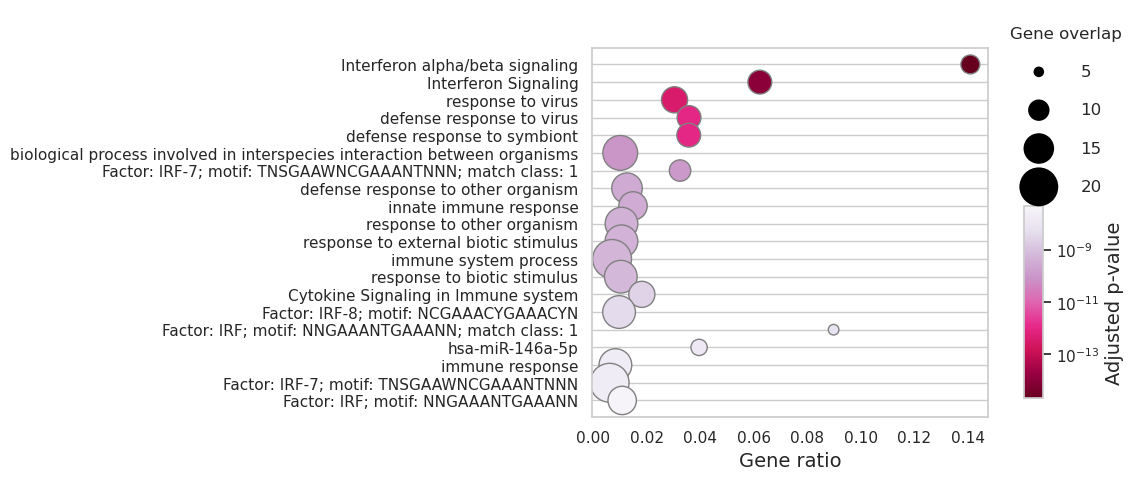

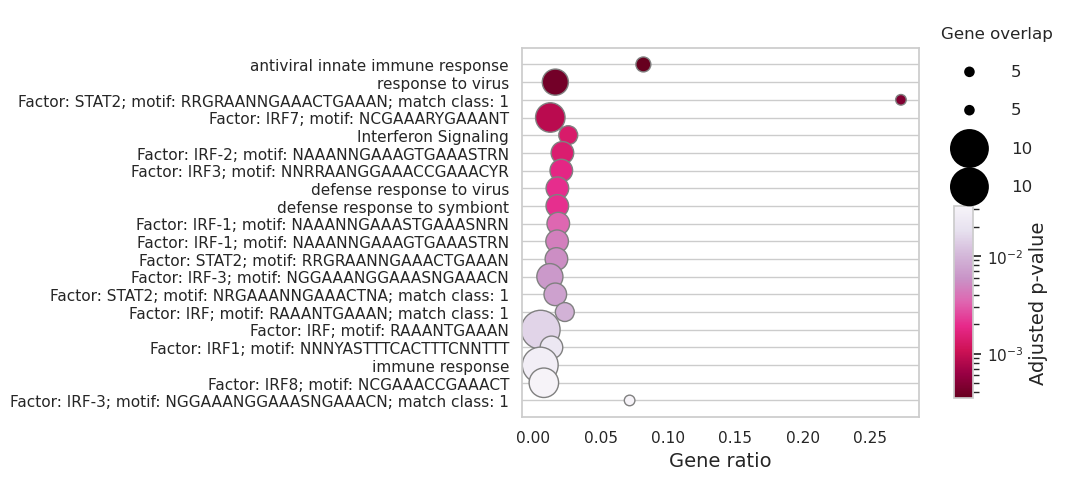

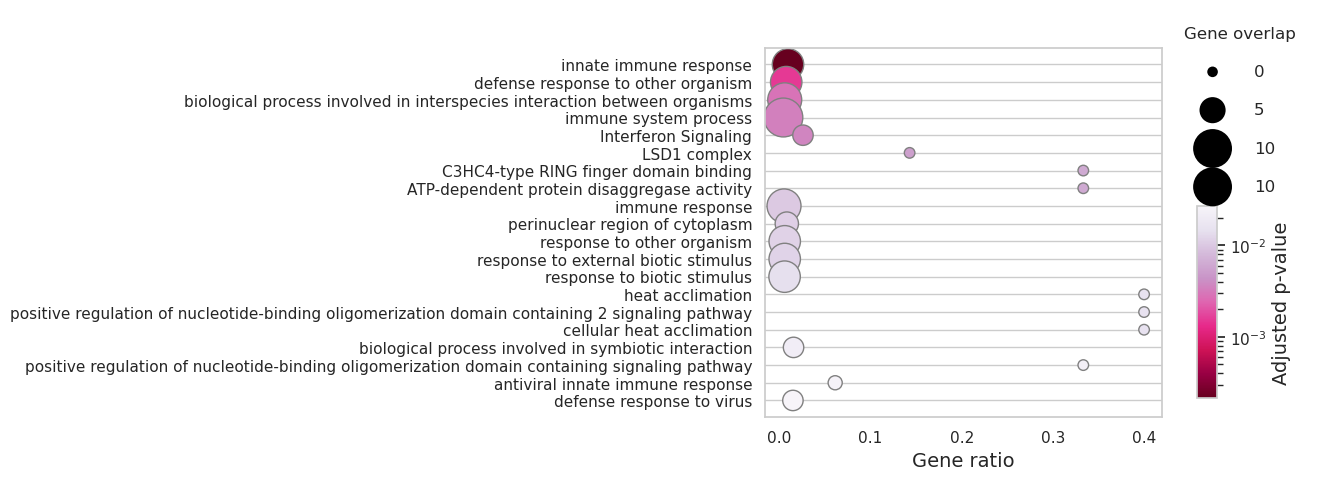

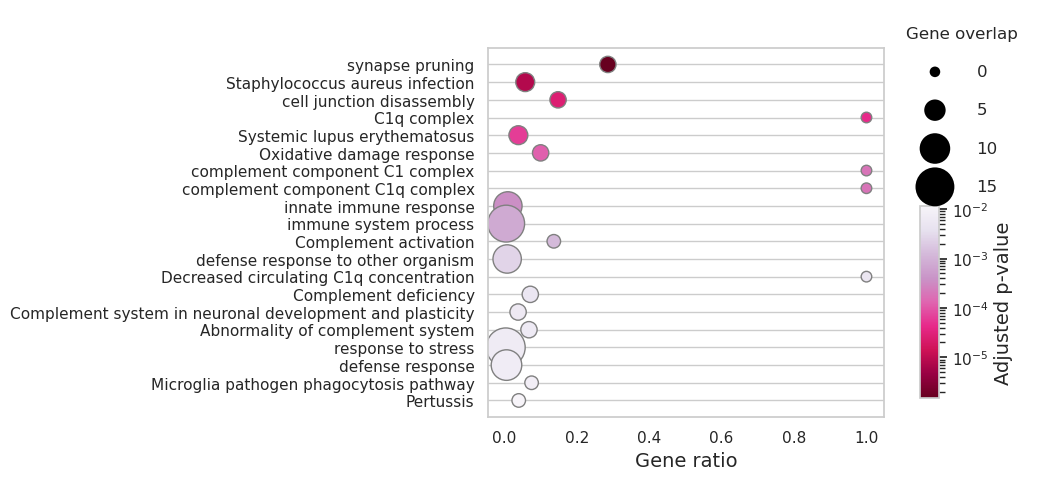

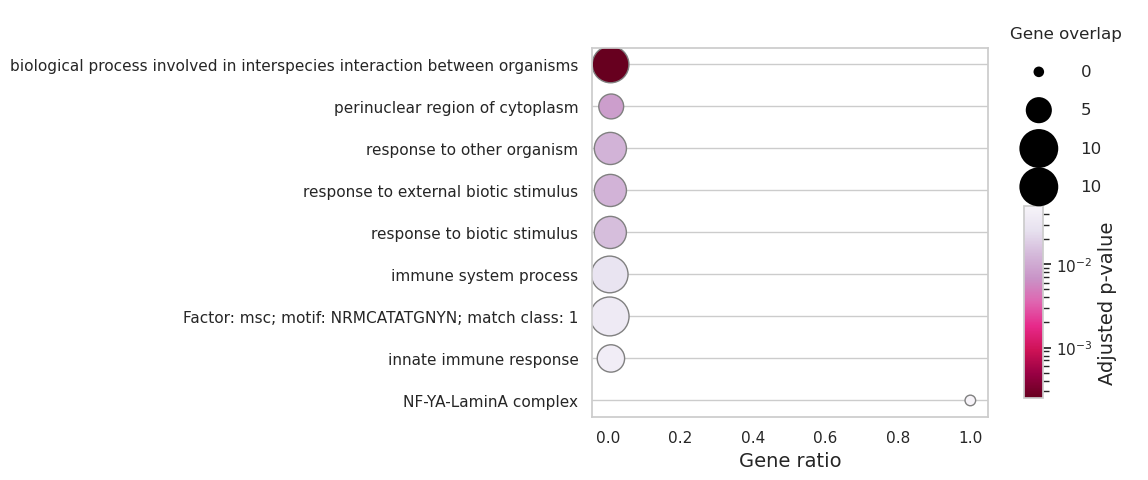

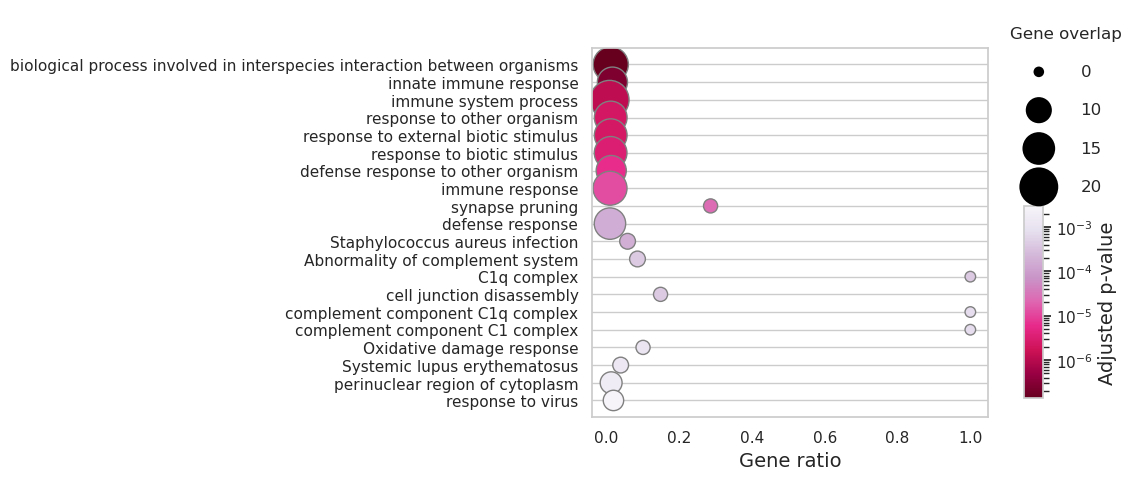

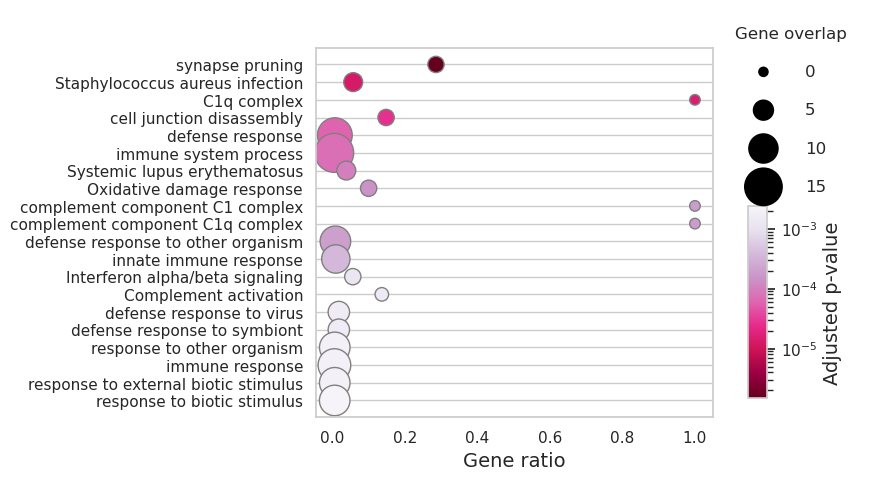

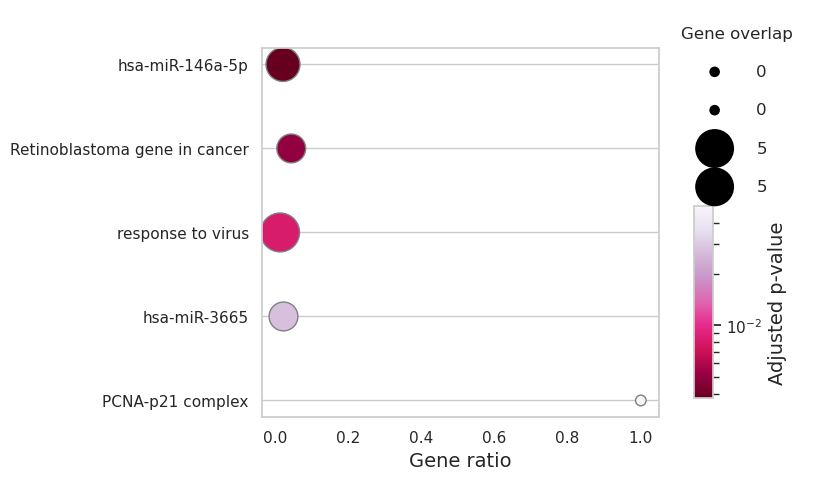

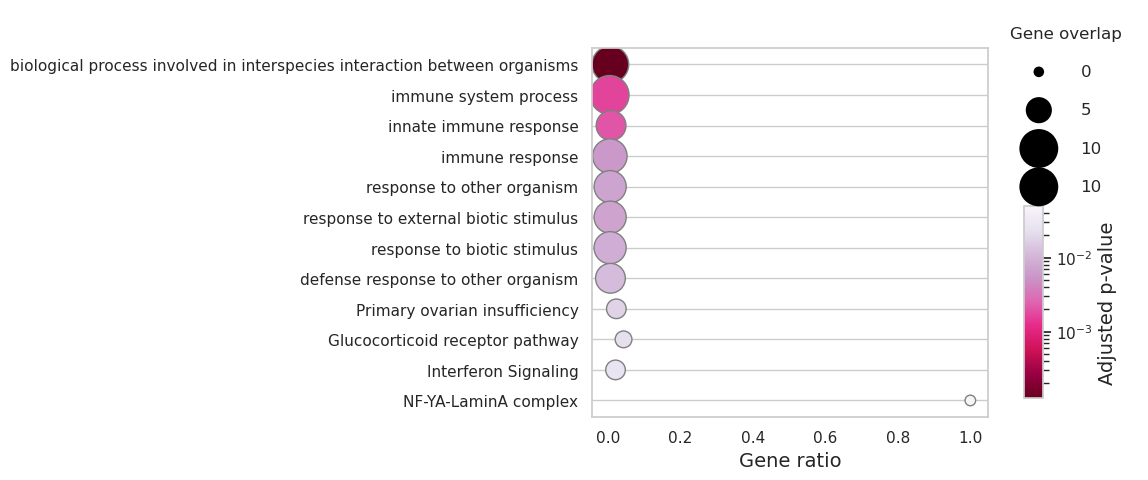

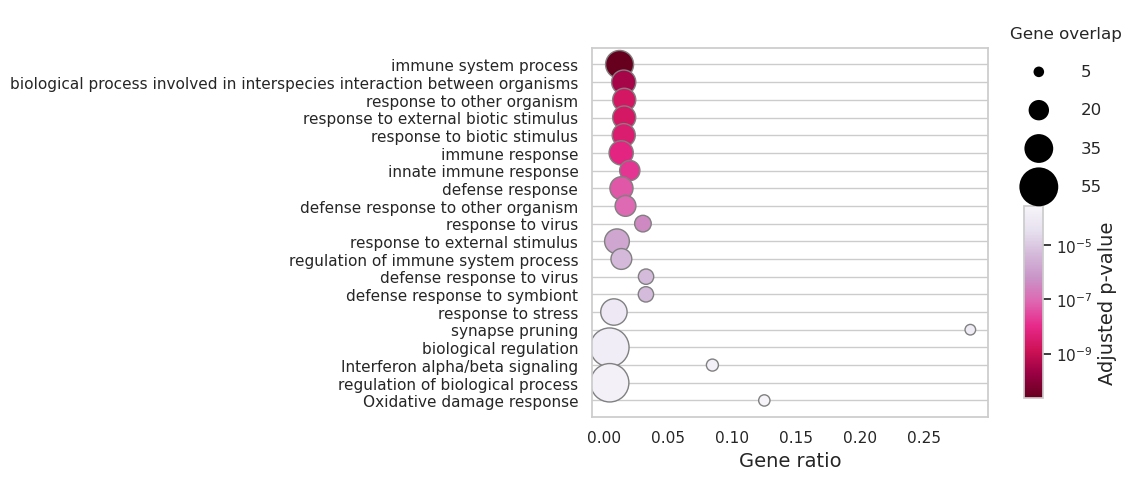

In [9]:
os.chdir("/mnt/d/scGPT/ldVAE/")

plot_enrich(data=tbl1, n_terms=20, save="Enrichments_Z14_model_1L128H14.pdf")
plot_enrich(data=tbl2, n_terms=20, save="Enrichments_Z2_model_1L128H8L250E.pdf")
plot_enrich(data=tbl3, n_terms=20, save="Enrichments_Z5_model_2L64H8L250E.pdf")

plot_enrich(data=tbl4_Z1, n_terms=20, save="Enrichments_Z1_model_1L64H8L250E.pdf")
plot_enrich(data=tbl4_Z6, n_terms=20, save="Enrichments_Z6_model_1L64H8L250E.pdf")
plot_enrich(data=tbl4_all, n_terms=20, save="Enrichments_all_model_1L64H8L250E.pdf")

plot_enrich(data=tbl5_Z4, n_terms=20, save="Enrichments_Z4_model_2L32H8L250E.pdf")
plot_enrich(data=tbl5_Z3, n_terms=20, save="Enrichments_Z3_model_2L32H8L250E.pdf")
plot_enrich(data=tbl5_Z2, n_terms=20, save="Enrichments_Z2_model_2L32H8L250E.pdf")
plot_enrich(data=tbl5_all, n_terms=20, save="Enrichments_all_model_2L32H8L250E.pdf")

In [17]:
# genes1
# sel1

IFIT3    -2.480609
IRF7     -2.081909
IFI44    -2.061164
IFI27    -1.740394
IFI44L   -1.670667
STAT1    -1.660984
IFI6     -0.986078
ISG15    -0.867415
HERC5    -0.368508
IFIT1    -0.356734
PLSCR1   -0.338391
THRB     -0.333067
IFITM3   -0.279398
IFIT2    -0.265365
SCO2     -0.241780
HSH2D    -0.239512
NCF1     -0.235093
MT2A     -0.221371
ITGAM    -0.217156
LY6E     -0.217143
EGR1     -0.211586
SAMD9    -0.210140
PTGDS    -0.202660
TCF4     -0.198926
CTNNB1   -0.193084
Name: Z_14, dtype: float32

In [10]:
# NB. Although model_1L64H8L250E shows no _enrichment_ for IFN1, 
# IFN1 targets are up in all monos, cDCs, and atypical B cells:

# genes4_Z1 include: IFITM3, IFIT2, IFIT3, CX3CR1
# genes4_Z6 include: IFI44, IFIT3, IFI27

In [11]:
genes4_Z1

array(['HSPA1B', 'MAFB', 'RP11-291B21.2', 'ASCL2', 'FCGR3B', 'IFITM3',
       'IGFBP7', 'MEG3', 'C1QC', 'VMO1', 'RP11-290F20.3', 'MS4A7',
       'CDKN1C', 'C1QB', 'LYPD2', 'SOX4', 'APOBEC3A', 'C1QA', 'IFIT2',
       'HMOX1', 'RHOC', 'IFIT3', 'FCGR3A', 'CX3CR1', 'HES4'], dtype=object)

In [12]:
genes4_Z6

array(['MIR4435-1HG', 'SLC4A10', 'CHRNA1', 'RP11-403A21.2', 'DUSP4',
       'HMOX1', 'TIGIT', 'HSPA1A', 'LMNA', 'STOM', 'KLRG1', 'IFI44',
       'RGS1', 'MYBL1', 'LPAR6', 'SAP30', 'GZMK', 'IFIT3', 'FAM46C',
       'IFI27', 'ATG2A', 'GBP5', 'FAM129A', 'PRDM1', 'HERC5'],
      dtype=object)